In [ ]:
# Auto 이상탐지

In [2]:
originality from https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

SyntaxError: invalid syntax (3279240983.py, line 1)

In [19]:
# cv오류 해결하기
# pip install opencv-python 

In [20]:
# AutoEncoder를 사용한 이상탐지

정상인 데이터들 중에 소수의 비정상인 데이터가 포함되어 있다.

AutoEncoder를 사용하여 학습 시킨다.

이렇게 학습된 AutoEncoder는 대부분의 정상 데이터에 대하여 복원 능력이 있다. 하지만 소소의 비정상 데이터에 대해서는 제대로 복원하지 못한다.

이렇게 학습시킨 AutoEncoder를 가지고 특정영상을 복원 하게 하고 그 복원 결과가 좋지 않을 경우 정상영상이 아니라고 판정한다.

originality from 
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

In [21]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras import backend as K
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import random
import pickle
import cv2
import matplotlib

In [22]:
#pip install opencv-python

In [23]:
# 데이터 준비

## 데이터 로딩

((trainX, trainY), (testX, testY)) = mnist.load_data()

In [25]:
## 데이터셋 생성

#1의 레이블 영상이 정상이고 3의 레이블 영상이 비정상으로 한다.

#정상 영상과 비정상 영상의 비율을 100:1로 해서 골라내고, 골고루 섞은 데이터셋을 만든다.



def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):

  # 레이블 1인 영상의 인덱스
	validIdxs = np.where(labels == validLabel)[0]
  # 레이블 3인 영상의 인덱스
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

  # 무작위로 섞어 주고
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

  # 비정상 데이터의 갯수를 비정상 데이터 갯수 대비 0.01(contam)로 한다.
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	print("len(validIdx)=",len(validIdxs))
	print("len(anomalyIdxs)=",len(anomalyIdxs))

  # 추려낸 정상 데이터와 비정상 제이터
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

  # 두개의 데이터를 합하고, 다시 섞어주고
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	return images

In [26]:
images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=3, contam=0.01)

print(images.shape)
print(np.max(images))
print(np.min(images))

len(validIdx)= 6742
len(anomalyIdxs)= 67
(6809, 28, 28)
255
0


In [ ]:
## 데이터 모양 변경, Normalization

Conv2D 사용을 위해 데이터 모양을 (H, W, channel)의 3차원으로 만들고
(28, 28) -> (28, 28, 1)

0 ~ 1.0으로 normlaization 한다.

In [27]:
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

print(images.shape)
print(np.max(images))
print(np.min(images))

(6809, 28, 28, 1)
1.0
0.0


In [28]:
## 데이터 분리

(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

print(trainX.shape)
print(testX.shape)

print(trainX.shape)
print(testX.shape)

(5447, 28, 28, 1)
(1362, 28, 28, 1)
(5447, 28, 28, 1)
(1362, 28, 28, 1)


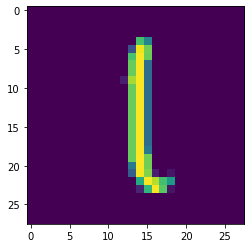

In [29]:
for i in range(10):
  plt.imshow(trainX[i].reshape((28,28)))
  
plt.show()

In [32]:
# 학습

## 모델 정의

class ConvAutoencoder:

	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		inputShape = (height, width, depth)
		chanDim = -1

		inputs = Input(shape=inputShape)
		x = inputs

		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		encoder = Model(inputs, latent, name="encoder")

		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		decoder = Model(latentInputs, outputs, name="decoder")



		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")


		return autoencoder

In [34]:
## 모델 생성

autoencoder = ConvAutoencoder.build(28, 28, 1)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69392     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         109377    
                                                                 
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


In [35]:
## 모델 컴파일

# decay값은 1 step 마다 감소하는 비율
opt = Adam(learning_rate=1e-3, decay=0.0025)
autoencoder.compile(loss="mse", optimizer=opt)

Epoch 1/20
154/154 [==============================] - 9s 46ms/step - loss: 0.0427 - val_loss: 0.0480
Epoch 2/20
154/154 [==============================] - 7s 43ms/step - loss: 0.0150 - val_loss: 0.0436
Epoch 3/20
154/154 [==============================] - 6s 42ms/step - loss: 0.0060 - val_loss: 0.0196
Epoch 4/20
154/154 [==============================] - 6s 42ms/step - loss: 0.0039 - val_loss: 0.0080
Epoch 5/20
154/154 [==============================] - 6s 42ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 6/20
154/154 [==============================] - 6s 41ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
154/154 [==============================] - 6s 42ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/20
154/154 [==============================] - 6s 42ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 9/20
154/154 [==============================] - 7s 42ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 10/20
154/154 [==============================] - 6s 42ms/step - loss: 0.0025 - val_lo

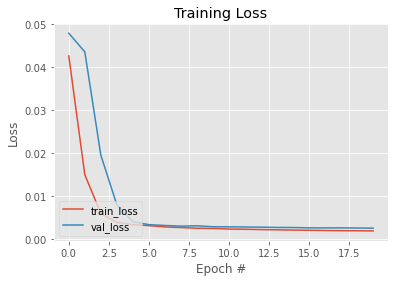

In [37]:
## 학습

history = autoencoder.fit(trainX, trainX, validation_split=0.1, epochs=20, batch_size=32)

N = np.arange(len(history.history['loss']))

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

43/43 [==============================] - 1s 15ms/step


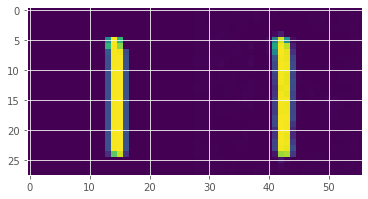

In [38]:
## 테스트 데이터에 대한 복원 실행

reconstructed = autoencoder.predict(testX)

for i in range(10):
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  
plt.show()

In [ ]:
# 이상 탐지

학습된 AutoEncoder는 1 영상(정상 영상)의 경우 잘 복원한다. 그러나 그렇지 않은 경우 잘 복원하지 못한다.


1의 영상은 정상이고, 3의 영상은 비정상이다.

또한 1이외의 정상 역시 비정상이다.

<br>

AutoEncoder를 사용하여 인코딩과 디코딩을 통해 복원하고, 복원된 것이 원본과 차이가 날 수록 비정상인것으로 판단한다.

In [39]:
## 복원 실행

reconstructed = autoencoder.predict(testX)

43/43 [==============================] - 1s 14ms/step


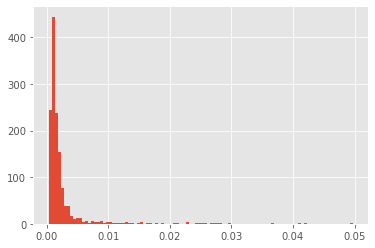

In [40]:
## 차이 계산

errors = []

for (image, recon) in zip(testX, reconstructed):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

plt.hist(errors, bins=100)
plt.show()

In [41]:
#데이터의 1/101이 비정상 데이터이다.

0.02439323263242847
14


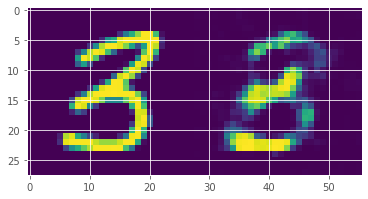

In [42]:
#quantile 0.99 이상이 되는 threshold를 구하자.

threshold = np.quantile(errors, 0.99)
print(threshold)

anomaly_idxs = np.where(np.array(errors) >= threshold)[0]
print(len(anomaly_idxs))

for i in anomaly_idxs:
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  
plt.show()

In [43]:
#비정상 영상인 3자와, 정말 이상하게 생긴 1자를 잘 찾아 냈다.

In [44]:
# 1과 3 이외의 입력

((trainX, trainY), (testX, testY)) = mnist.load_data()

testX = np.expand_dims(testX, axis=-1)
testX = testX.astype("float32") / 255.0

print(testX.shape)
print(reconstructed.shape)

(10000, 28, 28, 1)
(1362, 28, 28, 1)


313/313 [==============================] - 5s 16ms/step


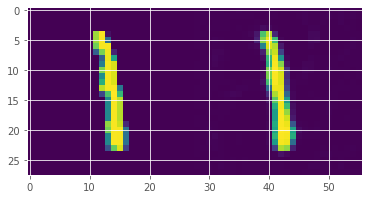

In [45]:
reconstructed = autoencoder.predict(testX)

for i in range(30):
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  
plt.show() 